<a href="https://colab.research.google.com/github/ekalachev/dl/blob/main/DL_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [ ]:
!pip install -q tensorflow==2.1

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


# Загружаем данные

In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [ ]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

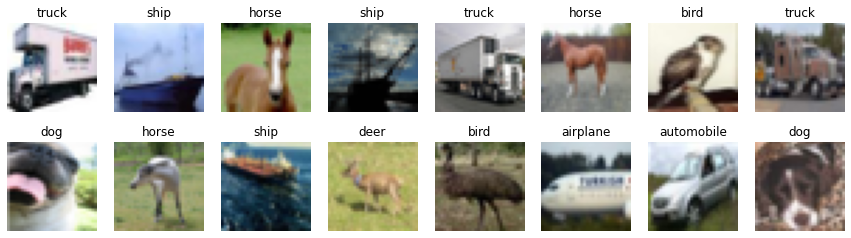

In [ ]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [ ]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [ ]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [ ]:
def make_default_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(63, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) # rate = 0.5
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [ ]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 63)        18207     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 63)          0

# Тренируем модель

In [ ]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [ ]:
# учим дефолтную архитектуру
train_model()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 179us/sample - loss: 1.4736 - accuracy: 0.4636 - val_loss: 1.0552 - val_accuracy: 0.6241
Epoch 2/10
50000/50000 [==============================] - 8s 166us/sample - loss: 1.0840 - accuracy: 0.6145 - val_loss: 0.8654 - val_accuracy: 0.6937
Epoch 3/10
50000/50000 [==============================] - 8s 165us/sample - loss: 0.9313 - accuracy: 0.6724 - val_loss: 0.8051 - val_accuracy: 0.7190
Epoch 4/10
50000/50000 [==============================] - 8s 166us/sample - loss: 0.8423 - accuracy: 0.7033 - val_loss: 0.7552 - val_accuracy: 0.7354
Epoch 5/10
50000/50000 [==============================] - 8s 165us/sample - loss: 0.7748 - accuracy: 0.7278 - val_loss: 0.7509 - val_accuracy: 0.7362
Epoch 6/10
50000/50000 [==============================] - 8s 166us/sample - loss: 0.7228 - accuracy: 0.7476 - val_loss: 0.7312 - val_accuracy: 0.7486
Epoch 7/10
50000/50000 [==========================

In [ ]:
def make_sigmoid_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(Conv2D(63, kernel_size=(3,3), padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Flatten())
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5)) # rate = 0.5
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [ ]:
# учим sigmoid
train_model(make_sigmoid_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 178us/sample - loss: 1.4292 - accuracy: 0.4923 - val_loss: 1.0493 - val_accuracy: 0.6350
Epoch 2/10
50000/50000 [==============================] - 8s 161us/sample - loss: 1.1067 - accuracy: 0.6099 - val_loss: 0.9550 - val_accuracy: 0.6674
Epoch 3/10
50000/50000 [==============================] - 8s 163us/sample - loss: 1.0378 - accuracy: 0.6368 - val_loss: 0.9324 - val_accuracy: 0.6739
Epoch 4/10
50000/50000 [==============================] - 8s 165us/sample - loss: 1.0134 - accuracy: 0.6460 - val_loss: 0.9380 - val_accuracy: 0.6682
Epoch 5/10
50000/50000 [==============================] - 8s 163us/sample - loss: 1.0116 - accuracy: 0.6466 - val_loss: 0.9167 - val_accuracy: 0.6827
Epoch 6/10
50000/50000 [==============================] - 8s 162us/sample - loss: 1.0051 - accuracy: 0.6461 - val_loss: 0.9001 - val_accuracy: 0.6856
Epoch 7/10
50000/50000 [==========================

In [ ]:
# учим sgd
train_model(optimizer="sgd")

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 179us/sample - loss: 2.0823 - accuracy: 0.2239 - val_loss: 1.7460 - val_accuracy: 0.3717
Epoch 2/10
50000/50000 [==============================] - 8s 158us/sample - loss: 1.6926 - accuracy: 0.3802 - val_loss: 1.5264 - val_accuracy: 0.4465
Epoch 3/10
50000/50000 [==============================] - 8s 161us/sample - loss: 1.5481 - accuracy: 0.4355 - val_loss: 1.4532 - val_accuracy: 0.4772
Epoch 4/10
50000/50000 [==============================] - 8s 159us/sample - loss: 1.4466 - accuracy: 0.4755 - val_loss: 1.3379 - val_accuracy: 0.5192
Epoch 5/10
50000/50000 [==============================] - 8s 158us/sample - loss: 1.3610 - accuracy: 0.5099 - val_loss: 1.3326 - val_accuracy: 0.5201
Epoch 6/10
50000/50000 [==============================] - 8s 151us/sample - loss: 1.2874 - accuracy: 0.5384 - val_loss: 1.2111 - val_accuracy: 0.5665
Epoch 7/10
50000/50000 [==========================

In [ ]:
def make_bn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(63, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # rate = 0.5
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [ ]:
# учим bn
train_model(make_bn_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 214us/sample - loss: 1.5008 - accuracy: 0.4861 - val_loss: 1.0311 - val_accuracy: 0.6324
Epoch 2/10
50000/50000 [==============================] - 10s 190us/sample - loss: 1.0437 - accuracy: 0.6306 - val_loss: 0.9762 - val_accuracy: 0.6616
Epoch 3/10
50000/50000 [==============================] - 10s 191us/sample - loss: 0.9112 - accuracy: 0.6803 - val_loss: 0.7590 - val_accuracy: 0.7349
Epoch 4/10
50000/50000 [==============================] - 10s 192us/sample - loss: 0.8136 - accuracy: 0.7164 - val_loss: 0.7223 - val_accuracy: 0.7456
Epoch 5/10
50000/50000 [==============================] - 10s 194us/sample - loss: 0.7475 - accuracy: 0.7383 - val_loss: 0.6714 - val_accuracy: 0.7680
Epoch 6/10
50000/50000 [==============================] - 10s 191us/sample - loss: 0.6884 - accuracy: 0.7607 - val_loss: 0.6779 - val_accuracy: 0.7621
Epoch 7/10
50000/50000 [====================

In [ ]:
def make_sigmoid_bn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='sigmoid', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Conv2D(63, kernel_size=(3,3), padding='same', activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25)) # rate = 0.25
    model.add(Flatten())
    model.add(Dense(256, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # rate = 0.5
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [ ]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 214us/sample - loss: 1.6011 - accuracy: 0.4283 - val_loss: 1.2795 - val_accuracy: 0.5416
Epoch 2/10
50000/50000 [==============================] - 10s 190us/sample - loss: 1.2126 - accuracy: 0.5726 - val_loss: 1.1723 - val_accuracy: 0.6016
Epoch 3/10
50000/50000 [==============================] - 10s 190us/sample - loss: 1.0674 - accuracy: 0.6267 - val_loss: 1.0038 - val_accuracy: 0.6531
Epoch 4/10
50000/50000 [==============================] - 9s 189us/sample - loss: 0.9803 - accuracy: 0.6584 - val_loss: 0.9442 - val_accuracy: 0.6738
Epoch 5/10
50000/50000 [==============================] - 9s 190us/sample - loss: 0.9261 - accuracy: 0.6769 - val_loss: 0.7933 - val_accuracy: 0.7247
Epoch 6/10
50000/50000 [==============================] - 9s 189us/sample - loss: 0.8702 - accuracy: 0.6953 - val_loss: 0.7985 - val_accuracy: 0.7163
Epoch 7/10
50000/50000 [=======================